### 1. Original Target Sound (from TSV)

Generating audio from target partials for comparison...
[2025-06-30 23:29:26] File saved successfully to: rendered_audio\target_additive_cello.wav


Generating and analyzing target signal...


### 2. Running Optimization

Optimizing with differential_evolution:   0%|          | 0/750 [00:00<?, ?iter/s]

Running differential_evolution with params: {'popsize': 15, 'tol': 0.0, 'atol': 0.0, 'disp': False}


### 3. Optimization Results


Optimization Complete.
Final Objective Value: 0.3137721185271882
Generating final audio using the 'differential_evolution' synthesis engine...


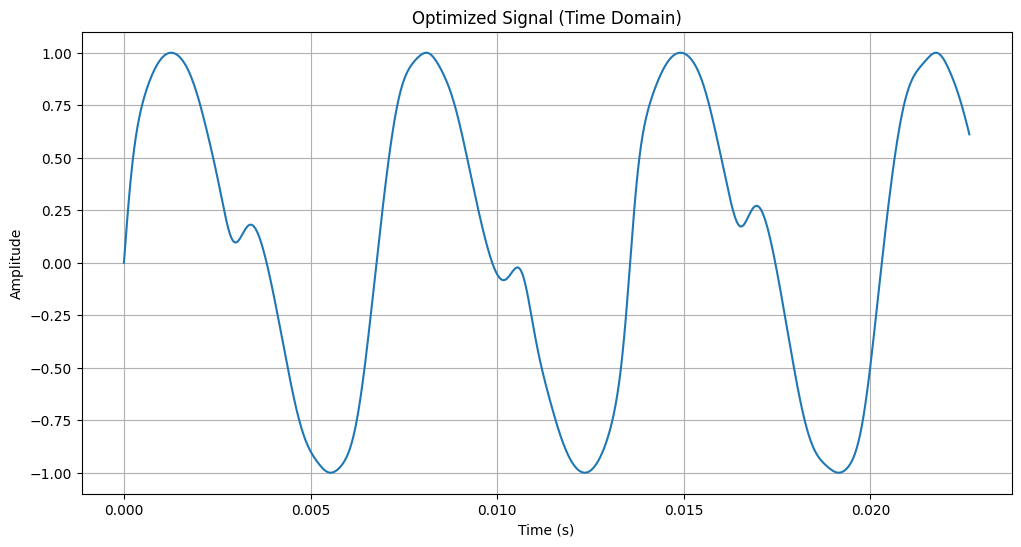

Using custom x-axis limit for plot: 15000 Hz


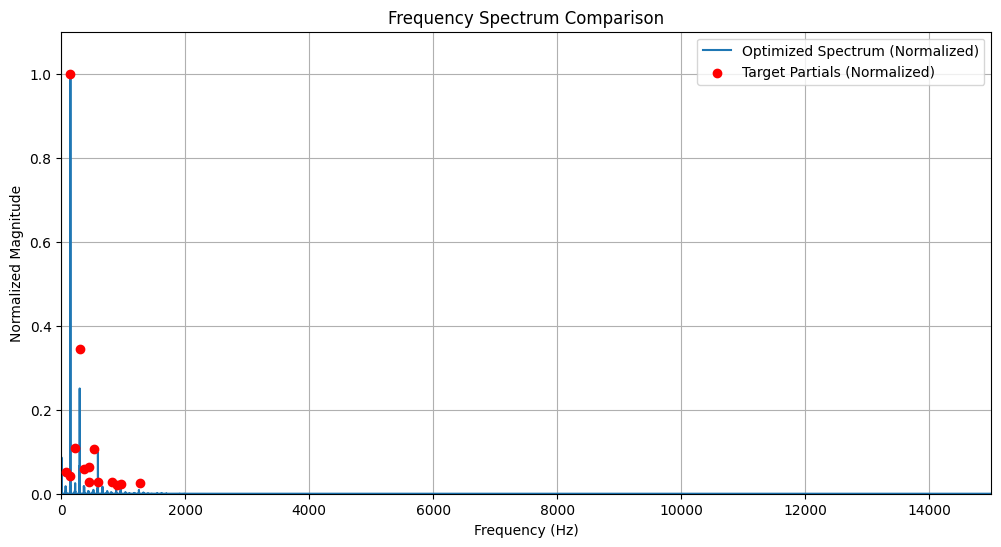

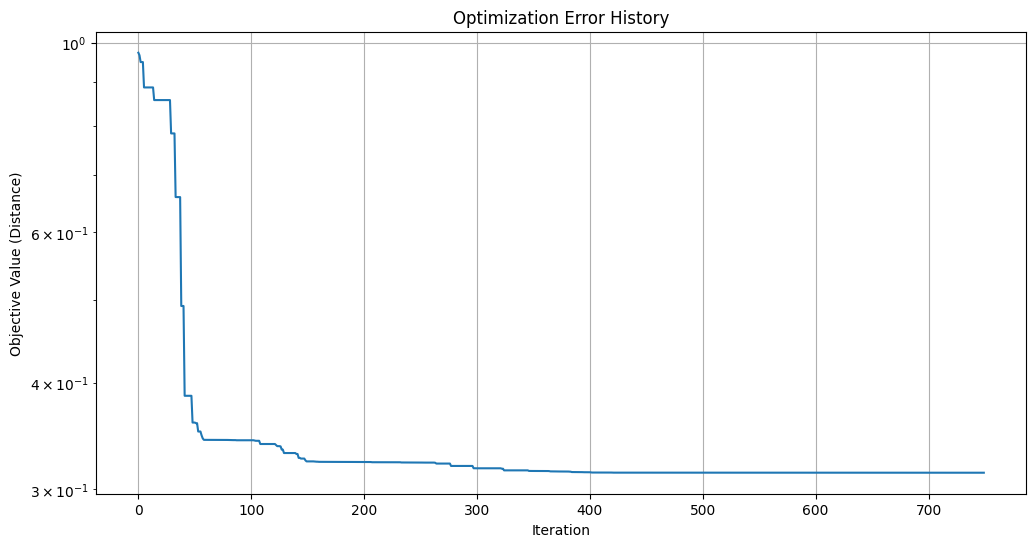


Optimal Parameters:
  Oscillator 1 (Carrier):
    Frequency: 147.00 Hz
    Amplitude: 10.15

  Oscillator 2 (Modulator for Osc 1):
    Frequency: 150.02 Hz
    Amplitude: 0.41

  Oscillator 3 (Modulator for Osc 2):
    Frequency: 294.00 Hz
    Amplitude: 0.91

  Oscillator 4 (Modulator for Osc 3):
    Frequency: 367.21 Hz
    Amplitude: 0.45



### 4. Optimized Sound (FM Synthesis)

[2025-06-30 23:32:39] File saved successfully to: rendered_audio\optimized_fm_cello_differential_evolution_cosine_similarity.wav


In [1]:
# main.py
import numpy as np
from IPython.display import Audio, display, Markdown
import os
import librosa
import cma

# --- PyTorch Imports ---
import torch
from optimization_torch import run_adam_optimization
from synthesis_torch import synthesize_fm_chain_torch

# --- NumPy/SciPy Imports ---
from utils import load_data
from synthesis import synthesize_fm_chain, sine_wave
from objectives import prepare_target, compute_fft
from optimization import define_objective_function, run_optimization
from plotting import plot_time_domain_signal, plot_frequency_domain_signal, plot_error_history
from generate_wave_file import save_wave_file

# --- 1. Configuration ---

OPTIMIZATION_CONFIG = {
    # --- General Settings ---
    'file_path': 'tsv/cello_single.tsv',
    'duration': 1,
    'sample_rate': 44100,
    
    # --- Synthesis & Objective Settings ---
    'n_oscillators': 4,
    'objective_type': 'cosine_similarity', # 'mfcc_distance', 'euclidean_distance', 'cosine_similarity', 'pearson_correlation_coefficient', 'itakura_saito' 
    
    # Set to a frequency in Hz (e.g., 15000) to see a wider spectrum.
    # Set to None to use the default automatic scaling.
    'plot_xlim_max': 15000,
    
    # --- Optimization Algorithm Settings ---
    'method': 'differential_evolution',
    'max_iterations': 750,
    'force_full_iters': True, # This is the key!
    'optimizer_params': {}
    
    # 'method': 'dual_annealing',
    # 'max_iterations': 1000,
    # 'force_full_iters': False, # Not needed if we set maxfun manually
    # 'optimizer_params': {'maxfun': 1e8} # Give it a budget of 100 million calls
    

    # 'method': 'cma', # <-- Set the method to 'cma'
    # # For CMA-ES, this is the budget of function evaluations (maxfevals)
    # 'max_iterations': 50000, 
    # 'force_full_iters': False, # This flag is ignored by the CMA-ES implementation

    # 'optimizer_params': {
    #     'sigma0': 0.5
    # } 
    
#         # --- Optimization Algorithm Settings ---
#     'method': 'adam', # <-- Set the method to 'adam'
#     'max_iterations': 5000, # For Adam, this is the number of update steps
    
#     # Adam doesn't use this flag
#     'force_full_iters': False, 
    
#     # Pass specific parameters to the Adam optimizer
#     'optimizer_params': {
#         'learning_rate': 0.1 # Learning rate is the most critical parameter for Adam
#     } 

}


# Unpack config into variables for cleaner code below
FILE_PATH = OPTIMIZATION_CONFIG['file_path']
DURATION = OPTIMIZATION_CONFIG['duration']
SAMPLE_RATE = OPTIMIZATION_CONFIG['sample_rate']
N_OSCILLATORS = OPTIMIZATION_CONFIG['n_oscillators']
OBJECTIVE_TYPE = OPTIMIZATION_CONFIG['objective_type']
OPTIMIZATION_METHOD = OPTIMIZATION_CONFIG['method']
MAX_ITERATIONS = OPTIMIZATION_CONFIG['max_iterations']
PLOT_XLIM_MAX = OPTIMIZATION_CONFIG.get('plot_xlim_max') # Use .get() for safety

# --- 2. Load Data ---
frequencies, amplitudes = load_data(FILE_PATH)

# --- 3. Generate and Render Original Target Sound (Additive Synthesis) ---
display(Markdown("### 1. Original Target Sound (from TSV)"))
print("Generating audio from target partials for comparison...")

# Create the signal by summing sine waves
target_signal = np.zeros(int(SAMPLE_RATE * DURATION))
for freq, amp in zip(frequencies, amplitudes):
    target_signal += sine_wave(freq, amp, DURATION, SAMPLE_RATE)

# Normalize the target signal before saving
max_val = np.max(np.abs(target_signal))
if max_val > 0:
    target_signal /= max_val

# Save and display the target audio
target_audio_path = save_wave_file(
    signal=target_signal,
    source_sr=SAMPLE_RATE,
    filename="target_additive_cello.wav"
)
display(Audio(filename=target_audio_path))

# --- 4. Prepare NumPy Target Data (for non-Adam and comparison) ---
# It's okay to prepare this here, as it's used by multiple parts.
target_data_np = prepare_target(frequencies, amplitudes, DURATION, SAMPLE_RATE, OBJECTIVE_TYPE)

# --- 5. Define Optimization Problem ---
bounds = []
for i in range(N_OSCILLATORS):
    bounds.append((1, 5000))
    bounds.append((0, 12))

# --- 6. Run Optimization ---
display(Markdown("### 2. Running Optimization"))

if OPTIMIZATION_METHOD in ['differential_evolution', 'dual_annealing', 'cma']:
    # --- FIX #2: Define the SciPy objective function only when needed ---
    objective_function = define_objective_function(OBJECTIVE_TYPE, target_data_np, DURATION, SAMPLE_RATE)
    result, error_history = run_optimization(
        method=OPTIMIZATION_METHOD,
        bounds=bounds,
        objective_func=objective_function,
        max_iters=MAX_ITERATIONS,
        force_full_iters=OPTIMIZATION_CONFIG['force_full_iters'],
        **OPTIMIZATION_CONFIG['optimizer_params']
    )
    optimal_params = result.x

elif OPTIMIZATION_METHOD == 'adam':
    # --- FIX #1: The COMPLETE Adam workflow block ---
    from objectives_torch import TORCH_METRIC_FEATURE_TYPE
    feature_type = TORCH_METRIC_FEATURE_TYPE.get(OBJECTIVE_TYPE)

    print(f"Preparing PyTorch target for objective: {OBJECTIVE_TYPE}")
    if feature_type == 'spectrum':
        target_data_torch = torch.from_numpy(target_data_np).float()
    elif feature_type == 'mfcc':
        from objectives_torch import compute_mfcc_torch
        target_signal_torch = torch.from_numpy(target_signal).float() # Use the target signal from Step 3
        target_data_torch = compute_mfcc_torch(target_signal_torch, SAMPLE_RATE)
    else:
        raise ValueError(f"Unsupported feature type for Adam: {feature_type}")
    
    initial_params = [np.random.uniform(low, high) for low, high in bounds]
    
    # The crucial missing call to run the optimization
    result, error_history = run_adam_optimization(
        objective_type=OBJECTIVE_TYPE,
        target_data=target_data_torch,
        initial_params=initial_params,
        bounds=bounds,
        duration=DURATION,
        sample_rate=SAMPLE_RATE,
        max_iters=MAX_ITERATIONS,
        **OPTIMIZATION_CONFIG['optimizer_params']
    )
    optimal_params = result.x
    # --- End of complete Adam block ---
else:
    raise ValueError(f"Unsupported optimization method: {OPTIMIZATION_METHOD}")

# --- 7. Process and Analyze Results ---
display(Markdown("### 3. Optimization Results"))
print("\nOptimization Complete.")
print(f"Final Objective Value: {result.fun}")

optimal_params = result.x
optimal_frequencies = optimal_params[0::2]
optimal_amplitudes = optimal_params[1::2]

# --- FIX #1: Use the correct synthesis function based on the method used ---
print(f"Generating final audio using the '{OPTIMIZATION_METHOD}' synthesis engine...")
if OPTIMIZATION_METHOD == 'adam':
    # Use the PyTorch synthesizer
    params_tensor = torch.from_numpy(optimal_params).float()
    optimized_signal_tensor = synthesize_fm_chain_torch(params_tensor, DURATION, SAMPLE_RATE)
    # Convert back to NumPy for plotting and saving
    optimized_signal = optimized_signal_tensor.detach().numpy()
else:
    # Use the NumPy synthesizer for all other methods
    optimized_signal = synthesize_fm_chain(optimal_params, DURATION, SAMPLE_RATE)
    
fft_magnitude, fft_freqs = compute_fft(optimized_signal, SAMPLE_RATE)

# Call the plotting functions with the new parameter
plot_time_domain_signal(optimized_signal, SAMPLE_RATE)
plot_frequency_domain_signal(
    fft_freqs,
    fft_magnitude,
    frequencies,
    amplitudes,
    xlim_max=PLOT_XLIM_MAX # Pass the new parameter here
)
plot_error_history(error_history)

# Print optimal parameters
print("\nOptimal Parameters:")
for i in range(N_OSCILLATORS):
    # --- THIS IS THE KEY CHANGE ---
    # The Carrier is now the FIRST oscillator in the list (index 0)
    # The last modulator in the chain is Oscillator N (index N-1)
    if i == 0:
        role = "Carrier"
    else:
        # Osc 2 modulates Osc 1, Osc 3 modulates Osc 2, etc.
        role = f"Modulator for Osc {i}"

    print(f"  Oscillator {i+1} ({role}):")
    print(f"    Frequency: {optimal_frequencies[i]:.2f} Hz")
    print(f"    Amplitude: {optimal_amplitudes[i]:.2f}\n")


# --- 8. Synthesize and Display Optimized Sound ---
display(Markdown("### 4. Optimized Sound (FM Synthesis)"))

# Save and display the optimized audio ONCE
output_filename = f'optimized_fm_cello_{OPTIMIZATION_METHOD}_{OBJECTIVE_TYPE}.wav'
optimized_audio_path = save_wave_file(
    signal=optimized_signal,
    source_sr=SAMPLE_RATE,
    target_sr=44100,
    bit_depth=16,
    filename=output_filename
)
display(Audio(filename=optimized_audio_path))

Using custom x-axis limit for plot: 2000 Hz


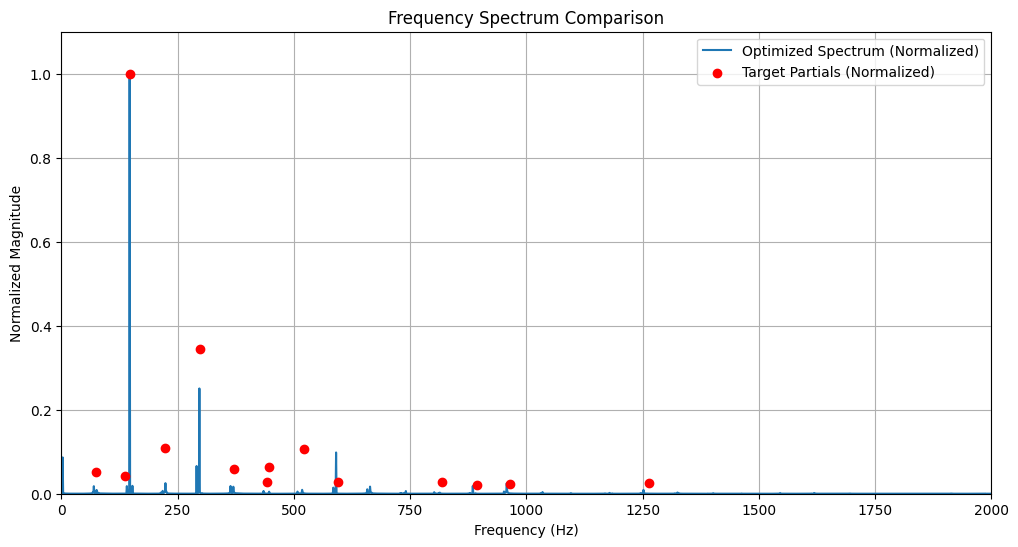

In [3]:
plot_frequency_domain_signal(
    fft_freqs,
    fft_magnitude,
    frequencies,
    amplitudes,
    xlim_max=2000 # Pass the new parameter here
)

In [4]:
# --- Follow-up Cell: Synthesize and Save a Longer Version ---

# You can change this to any desired duration in seconds
LONGER_DURATION = 10 

# You can also change the filename for the longer version
LONGER_FILENAME = f'optimized_fm_cello_{OPTIMIZATION_METHOD}_{OBJECTIVE_TYPE}_{LONGER_DURATION}s.wav'

print(f"Synthesizing a longer {LONGER_DURATION}-second version of the optimized sound...")

# --- Synthesis Logic ---
# We use the same logic as in the main cell to decide which synthesis engine to use.
# The ONLY difference is that we pass LONGER_DURATION instead of DURATION.

if OPTIMIZATION_METHOD == 'adam':
    # Use the PyTorch synthesizer
    # Convert optimal_params (which is a NumPy array) back to a PyTorch tensor
    params_tensor = torch.from_numpy(optimal_params).float()
    
    # Synthesize with the longer duration
    longer_signal_tensor = synthesize_fm_chain_torch(params_tensor, LONGER_DURATION, SAMPLE_RATE)
    
    # Convert the final signal back to a NumPy array for saving
    longer_optimized_signal = longer_signal_tensor.detach().numpy()
else:
    # Use the NumPy synthesizer for all other methods
    longer_optimized_signal = synthesize_fm_chain(optimal_params, LONGER_DURATION, SAMPLE_RATE)

# --- Save and Display the Longer Audio ---

# Call the save_wave_file utility with the new signal and filename
longer_audio_path = save_wave_file(
    signal=longer_optimized_signal,
    source_sr=SAMPLE_RATE,
    target_sr=44100, # Or any other target sample rate
    bit_depth=16,
    filename=LONGER_FILENAME
)

# Display the audio player for the longer version
display(Markdown(f"### Optimized Sound ({LONGER_DURATION} seconds)"))
display(Audio(filename=longer_audio_path))

Synthesizing a longer 10-second version of the optimized sound...
[2025-07-01 01:14:18] File saved successfully to: rendered_audio\optimized_fm_cello_differential_evolution_cosine_similarity_10s.wav


### Optimized Sound (10 seconds)

In [5]:
# --- Follow-up Cell: Automatically Save Preset with a Descriptive Name ---
import os
from datetime import datetime
from utils import save_preset

# This cell assumes 'optimal_params' and 'OPTIMIZATION_CONFIG' 
# exist in memory from the previous cell run.

print("Automatically generating preset name and saving...")

# --- 1. Auto-generate a descriptive name ---
# Get the base name of the source file (e.g., 'cello_single')
source_name = os.path.basename(OPTIMIZATION_CONFIG['file_path']).split('.')[0]
method = OPTIMIZATION_CONFIG['method']
objective = OPTIMIZATION_CONFIG['objective_type']
# Add a timestamp to ensure the filename is always unique
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Combine them into a single, descriptive filename
auto_preset_name = f"{source_name}_{method}_{objective}_{timestamp}"

# --- 2. Save the preset ---
preset_filepath = f'presets/{auto_preset_name}.json'

preset_metadata = {
    'optimization_method': method,
    'objective_type': objective,
    'n_oscillators': OPTIMIZATION_CONFIG['n_oscillators'],
    'source_file': OPTIMIZATION_CONFIG['file_path'],
    'final_loss': result.fun 
}

save_preset(preset_filepath, optimal_params, preset_metadata)

Automatically generating preset name and saving...
Preset saved successfully to: presets/cello_single_differential_evolution_cosine_similarity_20250701_011431.json


In [5]:
# --- Cell to Render Audio using the subprocess Module (with Debugging) ---
import subprocess
import shlex

# Define the preset and duration
preset_to_render = 'presets/testtt.json' # <-- DOUBLE-CHECK THAT THIS FILE EXISTS!
render_duration = 15
output_filename = "my_rendered_masterpiece.wav"

# Build the command as a list of arguments
command = [
    "python",
    "synthesizer_cli.py",
    "render",
    preset_to_render,
    "--duration",
    str(render_duration),
    "--output",
    output_filename
]

# --- Run the command inside a try...except block to see the error ---
print(f"Running command: {' '.join(command)}")
try:
    result = subprocess.run(command, capture_output=True, text=True, check=True)
    
    # This part will only run if the command succeeds
    print("\n--- Script Output (Success) ---")
    print(result.stdout)
    if result.stderr:
        print("\n--- Script Warnings (Success) ---")
        print(result.stderr)
    
    print("\n--- Rendering Complete ---")
    
    # Display the audio player on success
    from IPython.display import Audio, display
    display(Audio(filename=f'rendered_audio/{output_filename}'))

except subprocess.CalledProcessError as e:
    # This block will run if the command fails (returns a non-zero exit code)
    print("\n--- SCRIPT FAILED ---")
    print(f"Exit Code: {e.returncode}")
    
    print("\n--- Script Output (stdout) ---")
    # stdout might contain useful prints or partial output before the crash
    print(e.stdout)
    
    print("\n--- Script Error (stderr) ---")
    # stderr will almost always contain the Python traceback from the failed script
    print(e.stderr)

Running command: python synthesizer_cli.py render presets/testtt.json --duration 15 --output my_rendered_masterpiece.wav

--- Script Output (Success) ---
Preset loaded from: presets/testtt.json
Synthesizing a 15.0-second version using the 'adam' engine...
[2025-06-29 00:07:55] File saved successfully to: rendered_audio\my_rendered_masterpiece.wav


--- Rendering Complete ---
